In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
import pickle
import seaborn as sns
import multiprocessing

In [2]:
from joblib import parallel_backend
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
import re

In [20]:
# dask cluster location
cluster_loc = 'hpc'
prefix = 'plot'
tuneby = 'pasture'
logo_group = 'Pasture'
use_cuda = False
# set backend as one of 'multiprocessing' or 'dask'
backend = 'dask' 

inDIR = '../data/extractions/'
inFILE = '2023-2021_RobertsRanch-ResidualEstimates_USDA-ARS_hls_20231115.csv'
nickname = 'rr_snaplands'

inPATH = os.path.join(inDIR, inFILE)

outDIR = '../data/modeling/'
with open(os.path.join(outDIR, 'tmp',  'ml_train_' + nickname + '_cv_' + logo_group + '_tuneby_' + tuneby + '_results.pk'), 'rb') as f:
    mod_dict = pickle.load(f)

modelDIR = os.path.join('../output/models', nickname)
if not os.path.exists(modelDIR):
    os.path.mkdir(modelDIR)

# unique ID column name
id_col = 'SiteID'
# date column name
date_col = 'Date'
# dependent variable column
y_col = 'biomass_lb_ac'

save_results = False

var_names = [
    'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7', 'SAVI',
    'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI', 'TCGI', 'TCWI',
    'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246', 'BAI_346',
    'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2'
]

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'SAVI': 'savi',
    'RDVI': 'rdvi',
    'MTVI1': 'mtvi1', 
    'NCI': 'nci', 
    'NDCI': 'ndci',
    'PSRI': 'psri',
    'NDWI': 'ndwi',
    'EVI': 'evi',
    'TCBI': 'tcbi',
    'TCGI': 'tcgi',
    'TCWI': 'tcwi',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
#from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
import skorch
from skorch import NeuralNetRegressor

import sys
sys.path.insert(1, '../extract')
from hpc_setup import launch_dask
from dnn_setup import ResNetRegressor, ResidualBlock

if backend == 'dask':
    #from dask_ml.xgboost import XGBRegressor
    from dask_ml.model_selection import GridSearchCV
    from sklearn.model_selection import GridSearchCV as skGridSearchCV
else:
    #from xgboost import XGBRegressor
    from sklearn.model_selection import GridSearchCV


In [22]:
def vip(x, y, model):
    t = model.x_scores_
    #w = model.x_weights_
    w = model.x_rotations_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

def r2_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq

if backend == 'dask':
    import dask
    @dask.delayed
    def fit_ols(all_x, split_groups, df_train, lr_form, group_k, idx):
        r2_adj_tmp = []
        aic_tmp = []
        mae_orig_tmp = []
        for train_index_sub, test_index_sub in mod_logo.split(all_x, groups=split_groups):
            df_train_sub = df_train.iloc[train_index_sub]
            df_test_sub = df_train.iloc[test_index_sub]
            lreg_k_tmp = smf.ols(formula=lr_form, data=df_train_sub).fit()
            r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
            aic_tmp.append(lreg_k_tmp.aic)
            mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test_sub) - df_test_sub[y_col])))
        df_results_tmp = pd.DataFrame(dict(group=[group_k],
                                           group_name=[logo_group],
                                           numb_vars=[k_fold],
                                           formula=[lr_form],
                                           R2_adj=round(np.mean(r2_adj_tmp), 4),
                                           AIC=round(np.mean(aic_tmp), 4),
                                           mae_orig_mean=round(np.mean(mae_orig_tmp), 4)),
                                     index=[idx])
        return df_results_tmp

    @dask.delayed
    def fit_dnn(mod_base, batch_start, batch_size, all_x, all_y, loss_fn, optimizer):
        for start in batch_start:
            # take a batch
            X_batch = all_x[start:start+mod_dict[k]['batch_size']]
            y_batch = all_y[start:start+mod_dict[k]['batch_size']]
            # forward pass
            y_pred = mod_base(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        return mod_base

In [6]:
if backend == 'dask':
    num_jobs=16
    client = launch_dask(cluster_loc=cluster_loc, num_jobs=num_jobs, slurm_opts={'interface': 'ens7f0'})
    nthreads = len(client.nthreads())
    display(client)
else:
    nthreads = multiprocessing.cpu_count()
print(nthreads)

   setting up cluster on HPC...


/project/cper_neon_aop/conda_envs/py_seg_env/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33935 instead
  warnings.warn(


<Client: 'tcp://10.1.6.129:40529' processes=38 threads=76, memory=177.08 GiB>

38


In [23]:
if torch.has_cuda and use_cuda:
    device='cuda'
    print(torch.cuda.device_count())
else:
    device='cpu'
print(device)

cpu


In [24]:
rnr = NeuralNetRegressor(
    ResNetRegressor(ResidualBlock, layers=[3, 4, 6, 3], n_inputs=len(var_names)),
    criterion=nn.L1Loss,
    optimizer=optim.SGD,
    lr=0.001,
    max_epochs=100,
    batch_size=128,
    train_split=skorch.dataset.ValidSplit(0.2),
    callbacks=[skorch.callbacks.EarlyStopping(patience=10, load_best=True)],
    verbose=0, 
    device=device
)

In [25]:
df = pd.read_csv(inPATH, parse_dates=[date_col])

In [26]:
df['Year'] = df['Date'].dt.year

In [27]:
X_vars_all = df[var_names]
Y_var_all = df[y_col]

In [28]:
# check for any missing data
len(df[df[var_names].isnull().any(axis=1)])

0

In [29]:
# remove missing data
df = df[~df[var_names].isnull().any(axis=1)].copy()

In [30]:
df.head(5)

,SiteID,Pasture,Date,Year,Season,biomass_lb_ac,biomass_kg_ha,Lat,Long,_geometry,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2
0,FE-01,Campbell Springs,2023-10-13,2023,October,1156.0,1295.7604,40.812348,-105.207515,SRID=4326;POINT(-105.20751503041302 40.8123479...,...,134.820496,144.683016,134.106973,133.129152,623.249779,921.271677,1293.548976,2206.857647,3115.907835,2263.314248
1,FE-02,Campbell Springs,2023-10-13,2023,October,1054.0,1181.4286,40.815244,-105.201911,SRID=4326;POINT(-105.20191083218589 40.8152443...,...,133.162182,144.688298,132.303604,130.678393,613.936046,899.843649,1246.647314,2166.110909,3010.473601,2014.814815
2,FE-03,Upper Campbell Vally,2023-10-13,2023,October,1054.0,1181.4286,40.821796,-105.199079,SRID=4326;POINT(-105.19907926349288 40.8217955...,...,130.401742,140.166501,129.927720,129.322901,760.875937,1092.710679,1503.188702,2465.304786,3250.822844,2306.374057
3,FE-04,Upper Campbell Vally,2023-10-13,2023,October,986.0,1105.2074,40.820386,-105.196949,SRID=4326;POINT(-105.1969488811203 40.82038633...,...,133.149975,142.912301,132.834626,132.208042,773.103638,1109.953283,1512.533959,2464.517900,3485.905394,2540.632381
4,FE-05,Horsehoe North,2023-10-13,2023,October,1088.0,1219.5392,40.828931,-105.180927,SRID=4326;POINT(-105.18092750364805 40.8289305...,...,128.914306,140.923728,128.643906,127.442782,621.639054,959.267360,1339.883404,2305.939636,2966.570841,1974.473307


In [31]:
k = 'GBR'

In [32]:
#mod_dict[k]['param_grid'] = {
#    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
#    'min_samples_split': [0.001, 0.005, 0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
#    'n_estimators': [100, 200, 400, 600, 800],
#    'max_features': [0.1, 0.25, 0.5]
#}

In [33]:
if mod_dict[k]['fit']:
    df[k] = np.nan
else:
    print('ERROR: It appears that the selected model was not originally fit on the dataset for evaulation.')

#scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_groupk = GroupKFold(n_splits=10)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}

restart_dask = False

all_y_orig = df[y_col]
all_x_orig = df[var_names]

if mod_dict[k]['fit']:
    #restart_dask = True
    print('....fitting ' + k, end = " ")
    t0 = time.time()
    
    # prep data
    if mod_dict[k]['log_y']:
        all_y = np.log(1 + all_y_orig)
    else:
        all_y = all_y_orig.copy()
    if mod_dict[k]['scale_x']:
        scaler = mod_dict[k]['scaler']
        scaler.fit(all_x_orig)
        all_x = scaler.transform(all_x_orig)
    else:
        all_x = all_x_orig.copy()
    
    if mod_dict[k]['interactions']:
        poly_x = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                    interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
        all_x = poly_x.fit_transform(all_x)
        var_names_out = poly_x.get_feature_names_out(var_names)
    else:
        var_names_out = var_names

    if k == 'DNN':
        all_x = all_x.astype('float32')
        all_y = all_y.astype('float32').values.reshape(-1, 1)
        all_X = all_X.astype('float32')
        all_Y = all_Y.astype('float32')
        #client.scatter([DNNRegressor, dnnr], broadcast=True)
    
    # create a base model
    mod_base = mod_dict[k]['base_mod']
    
    if mod_dict[k]['tune']:
        if tuneby == 'year':
            split_groups = df['Date'].dt.year
            cv_splitter = mod_logo.split(all_x, groups=split_groups)
        elif tuneby == 'pasture':
            split_groups = df['Pasture']
            cv_splitter = mod_groupk.split(all_x, groups=split_groups)

        if 'OLS' in k:
            df_train = pd.merge(pd.DataFrame(data=all_y),
                                pd.DataFrame(columns=all_x_orig.columns, data=all_x, index=all_x_orig.index),
                                left_index=True,
                                right_index=True)
            df_test = pd.merge(pd.DataFrame(data=all_Y),
                                pd.DataFrame(columns=all_X_orig.columns, data=all_X, index=all_X_orig.index),
                                left_index=True,
                                right_index=True)
            if k == 'OLS_2022':
                form_fnl = mod_dict[k]['base_mod']
            else:
                idx = 0
                df_results_list = []
                for k_fold in range(1, 3 + 1):
                    for combo in itertools.combinations(var_names, k_fold):
                        combo_corr = df[np.array(combo)].corr()
                        if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
                            continue
                        else:
                            lr_form = mod_dict[k]['base_mod'] + combo[0]
                            if k_fold > 1:
                                for c in combo[1:]:
                                    lr_form = lr_form + ' + ' + c
                                for combo_c in itertools.combinations(combo, 2):
                                    lr_form = lr_form + ' + ' + combo_c[0] + ':' + combo_c[1]
                            df_results_tmp = fit_ols(all_x, split_groups, df_train, lr_form, logo_k, idx)
                            df_results_list.append(df_results_tmp)
                            #mod_dict[k]['formula_df'] = pd.concat([df_results_tmp.compute(), mod_dict[k]['formula_df']])
                            #break
                df_results = dask.compute(df_results_list)
                mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])
                if mod_dict[k]['tune_refit_type'] == 'minimize':
                    tune_loc = 0
                elif mod_dict[k]['tune_refit_type'] == 'maximize':
                    tune_loc = -1
                form_fnl = mod_dict[k]['formula_df'][mod_dict[k]['formula_df']['group'] == logo_k].sort_values(
                    mod_dict[k]['tune_refit'])['formula'].iloc[tune_loc]
            mod_fnl = smf.ols(formula=form_fnl, data=df_train).fit()
        
        elif k == 'MLP':
            from sklearn.model_selection import GridSearchCV as skGridSearchCV
            grid_search = skGridSearchCV(estimator=mod_base,
                                         param_grid=mod_dict[k]['param_grid'],
                                         scoring=scoring, 
                                         refit=mod_dict[k]['tune_refit'], 
                                         return_train_score=True,
                                         cv=cv_splitter, 
                                         n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                    len(client.nthreads())))
            with parallel_backend('threading'):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=ConvergenceWarning)
                    grid_search.fit(all_x, all_y)
            mod_fnl = mod_base.set_params(**grid_search.best_params_)
            mod_fnl.fit(all_x, all_y)
            mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
        elif k == 'DNN':
            from sklearn.model_selection import GridSearchCV as skGridSearchCV
            grid_search = skGridSearchCV(estimator=mod_base,
                                         param_grid=mod_dict[k]['param_grid'],
                                         scoring=scoring, 
                                         refit=mod_dict[k]['tune_refit'], 
                                         return_train_score=True,
                                         cv=cv_splitter, 
                                         n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                      len(client.nthreads())))
            grid_search.fit(all_x, all_y)
            mod_fnl = mod_base.set_params(**grid_search.best_params_)
            mod_fnl.fit(all_x, all_y)
            ax = plt.subplot()
            p_vl, = ax.plot(mod_fnl.history[:, 'valid_loss'], label='Validation')
            p_tl, = ax.plot(mod_fnl.history[:, 'train_loss'], label='Training')
            ax.legend(handles=[p_vl, p_tl])
            plt.show()
            mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
        else:
            grid_search = GridSearchCV(estimator=mod_base,
                                       param_grid=mod_dict[k]['param_grid'],
                                       scoring=scoring, 
                                       refit=mod_dict[k]['tune_refit'], 
                                       return_train_score=True,
                                       cv=cv_splitter, 
                                       n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                  nthreads))
            with parallel_backend(backend):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=ConvergenceWarning)
                    grid_search.fit(all_x, all_y)
            mod_fnl = mod_base.set_params(**grid_search.best_params_)
            mod_fnl.fit(all_x, all_y)
            mod_dict[k]['tune_results'] = grid_search.cv_results_
    else:
        if k == 'CPER_2022':
            mod_fnl = lr_mod
            all_x = all_x.rename(var_dict)
            all_X = all_X.rename(var_dict)
        elif k == 'DNN':
            mod_fnl = NeuralNetRegressor(
                ResNetRegressor(ResidualBlock, layers=[3, 4, 6, 3], n_inputs=len(var_names)),
                criterion=nn.L1Loss,#MAPELoss,
                optimizer=optim.SGD,
                lr=0.001,
                max_epochs=100,
                batch_size=batch_size,
                train_split=skorch.dataset.ValidSplit(0.2),
                callbacks=[skorch.callbacks.EarlyStopping(patience=10), skorch.callbacks.Checkpoint(dirname='results/dnn_checkpoints')],
                optimizer__momentum=0.85,
                optimizer__weight_decay=1e-3,
                optimizer__nesterov=True,
                verbose=1, 
                device=device)
            mod_fnl.fit(all_x, all_y)
            ax = plt.subplot()
            p_vl, = ax.plot(mod_fnl.history[:, 'valid_loss'], label='Validation')
            p_tl, = ax.plot(mod_fnl.history[:, 'train_loss'], label='Training')
            ax.legend(handles=[p_vl, p_tl])
            plt.show()
            cp = skorch.callbacks.Checkpoint(dirname='results/dnn_checkpoints')
            mod_fnl.initialize()
            mod_fnl.load_params(checkpoint=cp)
        else:
            mod_fnl = mod_base
            mod_fnl.fit(all_x, all_y)

    if mod_dict[k]['log_y']:
        if mod_dict[k] == 'OLS':
            preds = np.exp(mod_fnl.predict(df))
        else:
            preds = np.exp(mod_fnl.predict(all_x).squeeze()) + 1
    else:
        if mod_dict[k] == 'OLS':
            preds = mod_fnl.predict(df)
        else:
            preds = mod_fnl.predict(all_x).squeeze()
    df.loc[:, k] = preds
    print('(time to fit: ' + str(round(time.time() - t0, 2)) + ' secs)')

    # save temporary file to disk
    #df.to_csv(outFILE_tmp, index=False)

    #with open(os.path.join(outDIR, 'tmp', 'ml_train_' + nickname + '_cv_' + logo_group + '_tuneby_' + tuneby + '_results.pk'), 'wb') as fp:
    #    pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print('ERROR: model dictionary params not set to fit.')

....fitting GBR (time to fit: 144.86 secs)


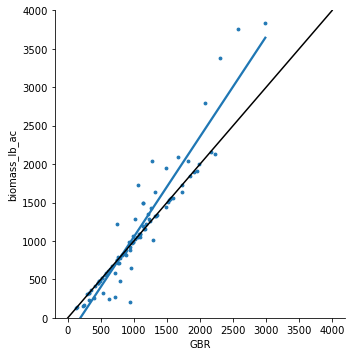

In [34]:
p_obs = sns.lmplot(df,
               x=k, y=y_col, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_obs.axes.flatten():
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [35]:
param_dfs = {}
param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results']['params']]))
param_dfs[k] = pd.DataFrame(columns=['Model', 'Best', 'MAPE', 'MSE', 'R2', 'R2_train'] + param_names)
df_tmp = pd.DataFrame({'Model': k,
                       'Best': 0,
                       'MAPE': mod_dict[k]['tune_results']['mean_test_MAPE'],
                       'MSE': mod_dict[k]['tune_results']['mean_test_MSE'],
                       'R2': mod_dict[k]['tune_results']['mean_test_R2'],
                       'R2_train': mod_dict[k]['tune_results']['mean_train_R2']})
for p in param_names:
    df_tmp[p] = mod_dict[k]['tune_results']['param_' + p].data
idx_best = mod_dict[k]['tune_results']['rank_test_MAPE'].argmin()
df_tmp.loc[idx_best, 'Best'] = 1
param_dfs[k] = pd.concat([param_dfs[k], df_tmp])

In [36]:
#param_dfs

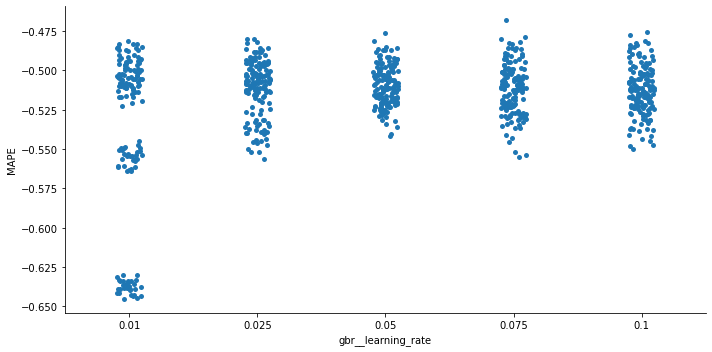

In [38]:
sns.catplot(x='gbr__learning_rate', y='MAPE', data=param_dfs['GBR'], aspect=2)

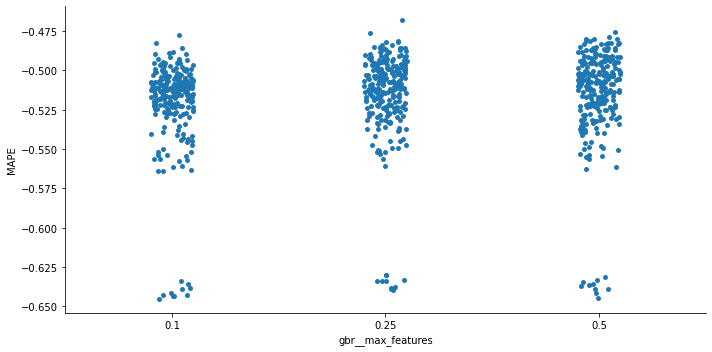

In [39]:
sns.catplot(x='gbr__max_features', y='MAPE', data=param_dfs['GBR'], aspect=2)

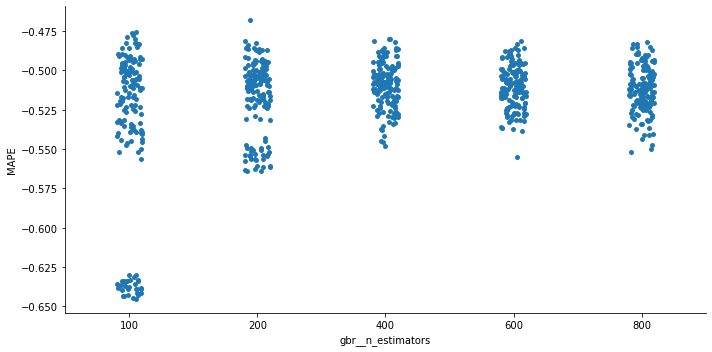

In [40]:
sns.catplot(x='gbr__n_estimators', y='MAPE', data=param_dfs['GBR'], aspect=2)

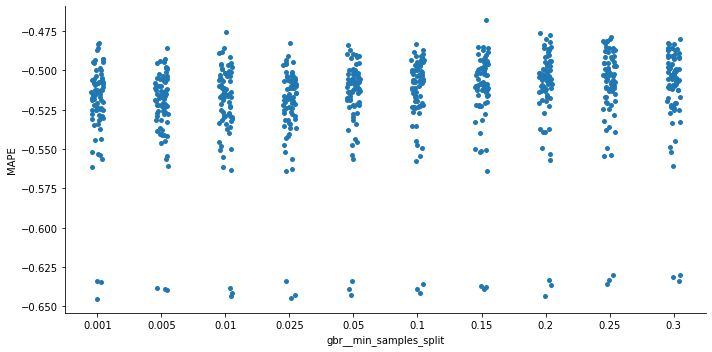

In [41]:
sns.catplot(x='gbr__min_samples_split', y='MAPE', data=param_dfs['GBR'], aspect=2)

In [48]:
mod_dict[k]['tune_results']['mean_test_MAPE'][mod_dict[k]['tune_results']['rank_test_MAPE'].argmin()]

-0.4681214732757126

In [49]:
grid_search.best_score_

-0.4681214732757126

In [50]:
mod_dict[k]['tune_results']['params'][mod_dict[k]['tune_results']['rank_test_MAPE'].argmin()]

{'gbr__learning_rate': 0.075,
 'gbr__max_features': 0.25,
 'gbr__min_samples_split': 0.15,
 'gbr__n_estimators': 200}

In [51]:
grid_search.best_params_

{'gbr__learning_rate': 0.075,
 'gbr__max_features': 0.25,
 'gbr__min_samples_split': 0.15,
 'gbr__n_estimators': 200}

In [52]:
with open(os.path.join(modelDIR, 'results_fnl_' + y_col + '_cv_' + logo_group + '_tuneby_' + tuneby + '.pk'), 'wb') as fp:
    pickle.dump(mod_dict[k], fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(modelDIR, 'mod_fnl_' + y_col + '_cv_' + logo_group + '_tuneby_' + tuneby + '.pk'), 'wb') as fp:
    pickle.dump(mod_fnl, fp, protocol=pickle.HIGHEST_PROTOCOL)